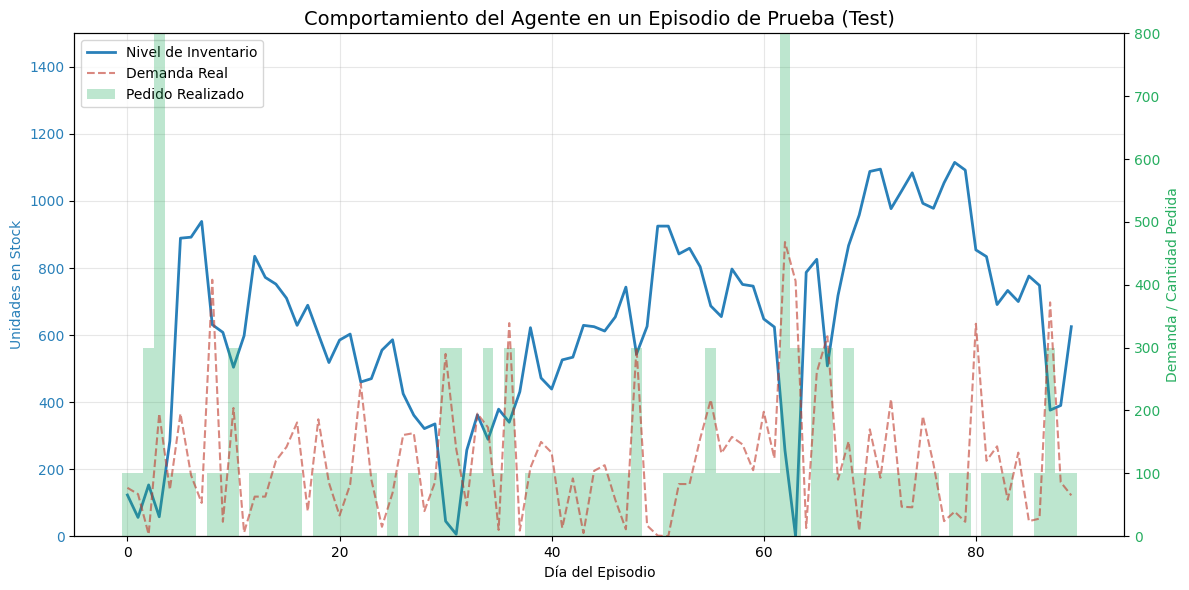

In [5]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# Llamar al entorno
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.environment_dqn import RetailEnvDQN

# 1. Configuración
MODELO_PATH = "../results/models/dqn/best_model/best_model.zip"
DATA_PATH = "../data/data_train.csv"

# 2. Cargar Datos
def cargar_datos_csv(ruta_csv):
    df_raw = pd.read_csv(ruta_csv)
    
    df_ordenado = pd.DataFrame()
    df_ordenado["dummy_inv"] = 0.0

    df_ordenado["forecast"] = df_raw["Demand Forecast"]
    df_ordenado["price"] = df_raw["Price"]
    df_ordenado["discount"] = df_raw["Discount"]
    df_ordenado["holiday"] = df_raw["Holiday/Promotion"]
    df_ordenado["competitor"] = df_raw["Competitor Pricing"]
    df_ordenado["weather"] = df_raw["Weather_Code"]
    df_ordenado["seasonality"] = df_raw["Seasonality_Code"]
    df_ordenado["units_sold"] = df_raw["Units Sold"]

    return df_ordenado.values.astype(np.float32)

# 3. Función para correr y registrar un episodio
def obtener_datos_episodio(env, model):
    obs, _ = env.reset()
    done = False
    
    hist_inventario = []
    hist_demanda = []
    hist_pedidos = []
    dias = []
    dia_actual = 0
    
    while not done:
        # Usar el modelo de forma determinista (sin aleatoriedad)
        action, _ = model.predict(obs, deterministic=True)
        
        obs, _, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # Guardar datos reales del diccionario 'info'
        hist_inventario.append(info['inventario'])
        hist_demanda.append(info['demanda']) 
        hist_pedidos.append(info['pedido_qty'])
        dias.append(dia_actual)
        dia_actual += 1
        
    return dias, hist_inventario, hist_demanda, hist_pedidos

# 4. Generar el Gráfico
if __name__ == "__main__":
    # Preparar datos y modelo
    data_full = cargar_datos_csv(DATA_PATH)
    
    # Usamos solo el final (Test)
    split_idx = 2924 # El mismo índice que se usó para cortar
    data_test = data_full[split_idx:] 
    
    env = RetailEnvDQN(data_test)
    env.disable_random_reset = True 
    env.fixed_start = 0 
    
    model = DQN.load(MODELO_PATH)
    
    # Obtener la historia
    dias, inv, dem, ped = obtener_datos_episodio(env, model)
    
    # Graficar
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eje Izquierdo: Inventario
    ax1.plot(dias, inv, color='#2980b9', linewidth=2, label='Nivel de Inventario')
    ax1.set_xlabel('Día del Episodio')
    ax1.set_ylabel('Unidades en Stock', color='#2980b9')
    ax1.tick_params(axis='y', labelcolor='#2980b9')
    ax1.set_ylim(0, 1500) # máxima capacidad de inventario
    ax1.grid(True, alpha=0.3)

    # Eje Derecho: Pedidos y Demanda (para que se vean bien las escalas)
    ax2 = ax1.twinx()
    
    # Demanda (Línea punteada roja)
    ax2.plot(dias, dem, color='#c0392b', linestyle='--', alpha=0.6, label='Demanda Real')
    
    # Pedidos (Barras verdes)
    # Usamos 'bar' con un ancho pequeño para que no tapen todo
    ax2.bar(dias, ped, color='#27ae60', alpha=0.3, width=1.0, label='Pedido Realizado')
    
    ax2.set_ylabel('Demanda / Cantidad Pedida', color='#27ae60')
    ax2.tick_params(axis='y', labelcolor='#27ae60')
    ax2.set_ylim(0, 800) # máximo pedido posible

    # Título y Leyenda combinada
    plt.title('Comportamiento del Agente en un Episodio de Prueba (Test)', fontsize=14)
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.tight_layout()
    plt.savefig("../results/plots/benchmark/episodio_detalle.png")
    plt.show()